C:\Users\Duong\AppData\Local\Temp\ipykernel_40388\1785522615.py:19: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


[0.0, 0.39072399999999996, 0.4869993, 0.500351358, 0.5186225999999999, 0.5354884, 1.0]


<IPython.core.display.Javascript object>


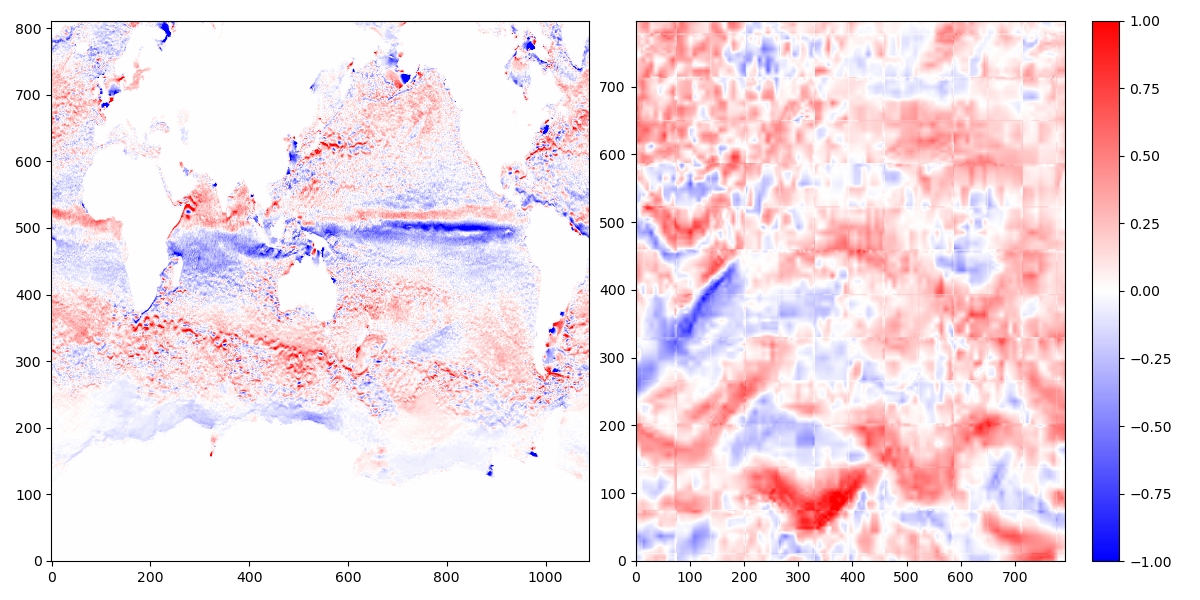

C:\Users\Duong\AppData\Local\Temp\ipykernel_40388\1785522615.py:185: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(plot)


interactive(children=(IntSlider(value=0, description='d', layout=Layout(width='300px'), max=4), Output()), _do…

interactive(children=(IntSlider(value=0, description='a', layout=Layout(width='300px'), max=4), Output()), _do…

interactive(children=(IntSlider(value=0, description='t', layout=Layout(width='1500px'), max=1023), Output()),…

In [4]:
import sys
sys.path.insert(0, 'F:/Workspace/idx2/build/Source/Python/Release')
sys.path.insert(0, 'D:/pascucci/ppt/2022/6_NASA/idx2/build/Source/Python/RelWithDebInfo')
#sys.path.insert(0, 'F:/Workspace/idx2/build/Source/Python/Debug')
import os
import idx2Py as i2p
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from ipywidgets import *
import concurrent.futures

path_prefix = 'J:/nasa/'
if not os.path.exists (path_prefix): 
  path_prefix = "W:/cedmav/hello/"

%matplotlib notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

vmin = -1
vmax = 1

## Set up color map

import colorsys

Points = [
  -10,
  -2.18552,
  -0.260014,
  0.00702716,
  0.372452,
  0.709768,
  10  
]

RGBPoints = [  
  [0.27843137254900002, 0.27843137254900002, 0.85882352941200002],
  [0.0, 0.33333333333333331, 1.0],
  [0.33333333333333331, 0.66666666666666663, 1.0],
  [0.0, 0.0, 0.49803921568627452],  
  [0.82745098039215681, 1.0, 0.73333333333333328],
  [1.0, 0.66666666666666663, 0.0],
  [0.87843137254899994, 0.30196078431399997, 0.30196078431399997]
]

def get_continuous_cmap(rgb_list, float_list=None):
  if float_list:
    # normalize the float list
    min_val = min(float_list)
    max_val = max(float_list)
    my_range = max_val - min_val
    float_list = [(v - min_val)/my_range for v in float_list]
    print(float_list)
  else:
    float_list = list(np.linspace(0, 1, len(rgb_list)))

  cdict = dict()  
  for num, col in enumerate(['red', 'green', 'blue']):
    col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(0, len(float_list))]
    cdict[col] = col_list
  cmp = matplotlib.colors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
  return cmp

my_cmap = get_continuous_cmap(RGBPoints, Points)

# Some helper functions

def get_file_name(input_dir, dataset, field, face, depth, time_from, time_to):
  return input_dir + '/' + dataset + '/' + field + '-face-' + repr(face) + '-depth-' + repr(depth) + '-time-' + repr(time_from) + '-' + repr(time_to) + '.idx2' 

def get_extent(dataset, face):
  if dataset == 'llc4320':
    if (face < 2):
      return (0, 0, 4320, 12960)
    elif (face > 2):
      return (0, 0, 12960, 4320)
    return (0, 0, 4320, 4320)
  elif dataset == 'llc2160':
    if (face < 2):
      return (0, 0, 2160, 6480)
    elif (face > 2):
      return (0, 0, 6480, 2160)
    return (0, 0, 2160, 2160)

# Query 
# extent should be a 4-tuple: (from_x, from_y, dim_x, dim_y)
def query_data(input_dir, dataset, times_per_file, times_per_brick, field, face, depth, time, downsampling, accuracy, extent=None):
  # determine the time step range to query from
  file_time_from    = (time // times_per_file) * times_per_file
  file_time_to      = file_time_from + times_per_file
  time_in_file      = time % times_per_file
  time_extent_from  = (time_in_file // times_per_brick) * times_per_brick
  
  # split the extent into 4 pieces
  if extent == None:
    extent = get_extent(dataset, face)
  e0 = extent
  e1 = (e0[0]           , e0[1]           , e0[2]//2   , e0[3]//2   )
  e2 = (e0[0]+(e0[2]//2), e0[1]           , e0[2]-e1[2], e0[3]//2   )
  e3 = (e0[0]           , e0[1]+(e0[3]//2), e0[2]//2   , e0[3]-e1[3])
  e4 = (e0[0]+(e0[2]//2), e0[1]+(e0[3]//2), e0[2]-e1[2], e0[3]-e1[3])
  e1 = (e1[0], e1[1], time_extent_from, e1[2], e1[3], times_per_brick)
  e2 = (e2[0], e2[1], time_extent_from, e2[2], e2[3], times_per_brick)
  e3 = (e3[0], e3[1], time_extent_from, e3[2], e3[3], times_per_brick)
  e4 = (e4[0], e4[1], time_extent_from, e4[2], e4[3], times_per_brick)

  file = get_file_name(input_dir, dataset, field, face, depth, file_time_from, file_time_to)
    
  array = None
  if extent[2] < 16 or extent[3] < 16: # if too small, don't spawn threads
    e = (extent[0], extent[1], time_extent_from, extent[2], extent[3], times_per_brick)
    array = i2p.DecodeExtent3f32(file, input_dir, extent, downsampling, accuracy)
  else:
    with concurrent.futures.ThreadPoolExecutor() as executor:
      f1 = executor.submit(i2p.DecodeExtent3f32, file, input_dir, e1, downsampling, accuracy)    
      f2 = executor.submit(i2p.DecodeExtent3f32, file, input_dir, e2, downsampling, accuracy)
      f3 = executor.submit(i2p.DecodeExtent3f32, file, input_dir, e3, downsampling, accuracy)
      f4 = executor.submit(i2p.DecodeExtent3f32, file, input_dir, e4, downsampling, accuracy)
      a1 = f1.result()
      a2 = f2.result()
      a3 = f3.result()
      a4 = f4.result()
      shape = (a1.shape[0], a1.shape[1] + a4.shape[1], a1.shape[2] + a4.shape[2])
      array = np.empty(shape)

      array[:, :a1.shape[1], :a1.shape[2]] = a1
      array[:, :a2.shape[1], a1.shape[2]:] = a2
      array[:, a1.shape[1]:, :a3.shape[2]] = a3
      array[:, a1.shape[1]:, a3.shape[2]:] = a4
  
  return array

# Zoomed in visualization


input_dir = path_prefix + 'llc4320_64'
dataset = 'llc4320'
n = 4320
times_per_file = 64
times_per_brick = 64
face = 0
depth = 0
time = 0
accuracy = 1
accuracy2 = 0.1
downsampling = [4, 4, 2]
downsampling2 = [0, 0, 0]
array = np.empty((1,1,1))
array2 = np.empty((1,1,1))

xbegin = 100
ybegin = 300
xdim   = 50
ydim   = 50

plt.close()

with concurrent.futures.ThreadPoolExecutor() as executor:
    f0 = executor.submit(query_data, input_dir, dataset, times_per_file, times_per_brick, 'u', 0, depth, time, downsampling, accuracy)    
    f1 = executor.submit(query_data, input_dir, dataset, times_per_file, times_per_brick, 'u', 1, depth, time, downsampling, accuracy)
    f3 = executor.submit(query_data, input_dir, dataset, times_per_file, times_per_brick, 'v', 3, depth, time, downsampling, accuracy)
    f4 = executor.submit(query_data, input_dir, dataset, times_per_file, times_per_brick, 'v', 4, depth, time, downsampling, accuracy)
    a0 = f0.result()
    a1 = f1.result()
    a3 = f3.result()
    a4 = f4.result()    
    dx = a0.shape[2]
    dy = a0.shape[1]
    dt = a0.shape[0]  
    array = np.empty((dt, dy, dx*4))
    array[:, :, dx*0:dx*1] = a0[:, :, :]    
    array[:, :, dx*1:dx*2] = a1[:, :, :]
    for tt in range(0, dt):
      array[tt, :, dx*2:dx*3] = np.rot90(a3[tt, :, :])
      array[tt, :, dx*3:dx*4] = np.rot90(a4[tt, :, :])
    #print(array.shape)

px = 1/plt.rcParams['figure.dpi']  # pixel in inches
fig, (ax, ax2) = plt.subplots(1,2)
fig.set_size_inches(12, 6)
plot = ax.imshow(array[0, :, :], origin = 'lower', cmap = 'bwr', aspect = 'auto', vmin = vmin, vmax = vmax)
plt.colorbar(plot)

fig.tight_layout()

def to_face(f):
  return f+1 if f >= 2 else f

def query_region():
  global array, array2, xbegin, ybegin, face, depth
  d = (array.shape[2], array.shape[1])
  D = (4320 * 4, 4320 * 3)
  s = (D[0] / d[0], D[1] / d[1])
  extent = (int(xbegin*s[0]), int(ybegin*s[1]), int(xdim*s[0]), int(ydim*s[1]))
  #print(extent)

  # query the data for the ROI
  futures = []
  with concurrent.futures.ThreadPoolExecutor() as executor:
    min_face = 4
    max_face = 0
    a = [np.empty((1,1,1), float)] * 4

    for ff in range(0, 4):
      f = to_face(ff)
      m = max(extent[0], n*ff)
      M = min(extent[0]+extent[2], n*(ff+1))
      if m < M:
        e = (m-n*ff, extent[1], M-m, extent[3]) if f < 2 else (n*3-extent[1]-int(ydim*s[1]), m-n*ff, extent[3], M-m)   
        if f < 2:
          a[ff] = query_data(input_dir, dataset, times_per_file, times_per_brick, 'u', f, depth, time, downsampling2, accuracy2, e)  
        else:
          a[ff] = query_data(input_dir, dataset, times_per_file, times_per_brick, 'v', f, depth, time, downsampling2, accuracy2, e)  
        min_face = min(min_face, ff)
        max_face = max(max_face, ff)
    dt = a[min_face].shape[0]            
    b = [np.empty((1, 1, 1), float)] * (max_face+1-min_face)
    for face in range(min_face, max_face + 1):
      f = face - min_face
      if face < 2:
        b[f] = a[face]
      else:
        b[f] = np.empty((dt, a[face].shape[2], a[face].shape[1]))
        for tt in range(0, dt):
          b[f][tt, :, :] = np.rot90(a[face][tt, :, :])        
    array2 = np.concatenate(b, 2)


query_region()
plot2 = ax2.imshow(array2[0, :, :], origin = 'lower', cmap = 'bwr', aspect = 'auto', vmin = vmin, vmax = vmax)

time_block = 0

current_time = 0

def f(t): # get time step t   
  global time_block, array, first_draw
  current_time = t
  curr_time_block = t // times_per_brick
  if curr_time_block != time_block:        
    time_block = curr_time_block
    query_region()
  tt = min((t - time_block * times_per_brick) // pow(2, downsampling[2]), array.shape[0]-1)
  plot.set_data(array[tt, :,:])

def draw_region():
  global time_block, array2, first_draw2
  plot2.set_data(array2[0, :,:])

line1 = None
line2 = None
line3 = None
line4 = None

pause = True

def onClick(event):
  global pause
  pause ^= True
  
fig.canvas.mpl_connect('button_press_event', onClick)

def draw_rectangle():
  global line1, line2, line3, line4
  if line1 is not None:
    line1.pop(0).remove()
  if line2 is not None:
    line2.pop(0).remove()
  if line3 is not None:
    line3.pop(0).remove()
  if line4 is not None:
    line4.pop(0).remove()
  line1 = ax.plot([xbegin, xbegin], [ybegin, ybegin+ydim], color = 'r')
  line2 = ax.plot([xbegin, xbegin+xdim], [ybegin, ybegin], color = 'r')
  line3 = ax.plot([xbegin+xdim, xbegin+xdim], [ybegin, ybegin+ydim], color = 'r')
  line4 = ax.plot([xbegin, xbegin+xdim], [ybegin+ydim, ybegin+ydim], color = 'r') 

def change_resolution(d):  
  global downsampling2
  downsampling2 = (d, d, 0)
  query_region()
  draw_region()

accuracy_choices = [0.001, 0.01, 0.1, 1, 10]
  
def change_accuracy(a):
  global accuracy2
  accuracy2 = accuracy_choices[a]
  query_region()
  draw_region()

def animate(t):
  global pause
  if pause:
    return
  #global first_draw, array, array2, time_block
  plot2.set_data(array2[t//pow(2,downsampling[2]), :,:])
  return [plot2]

#interact(f, t = widgets.IntSlider(min = 0, max = 63, step = 1, value = 0, layout = Layout(width = '500px')));
anim = FuncAnimation(fig, animate, frames=times_per_brick, interval=100, blit=True, repeat=True)
interact(change_resolution, d = widgets.IntSlider(min = 0, max = 4, step = 1, value = downsampling2[0], layout = Layout(width = '300px')));
interact(change_accuracy, a = widgets.IntSlider(min = 0, max = len(accuracy_choices)-1, step = 1, value = 0, layout = Layout(width = '300px')));
interact(f, t = widgets.IntSlider(min = 0, max = 1023, step = 1, value = 0, layout = Layout(width = '1500px')));